# IMAGE COLORIZER

#### Sebastian Trattnig, Daniel Leustik

With the invention of the camera at the beginning of the 19th century, people were able to capture events forever.For a long time it was common practice to develop photos in black and white. With the reduction of the natural color spectrum a lot of information was lost. The colorful richness of that time could therefore not be captured.

With the help of Machine Learning, however, it is suddenly possible to bring color back into pictures that are actually black and white. Our motivation was therefore to be able to colorize existing photos with our own tool. There are already some existing tools, but they are mainly sold commercially. Other free services, on the other hand, often have restrictive usage rights, which makes unrestricted use impossible. Therefore the idea was born to develop a tool based on Machine Learning within the course.


Our initial plan was  as follows:
* We prepared a set of images, that would be used to train the algorithm
* Based on the results of our research about machine learning algorithms for image colorization, we would implement our own algorithm 
* Next step would be the training phase. The algorithm would be fed with the prepared training dataset of images on order to get a useful training model
* After the training phase selected images that have been transformed into black and white should be colorized properly again
* The resulting images of the colorization should then be compared to original color images pixel by pixel to determine the accuracy of our implementation 


In [16]:
import os
from PIL import Image
from IPython.display import display

## THEORY

LITERATUR: https://arxiv.org/abs/1712.03400

### Hyperparameters

## DATA ANALYSIS

Having the right data as input is crucial for getting the right output. At first, we tried to find enough images in our private repositories. As part of our research we found out that it would take several thousands of images for the training. Even if we were able to provide such a huge amount of images, another requirement is a high diversity of what is actually pictured. So we had to find a suitable library of images on the internet.

In the end we came across "Caltech 256 Image Dataset" (http://www.vision.caltech.edu/Image_Datasets/Caltech256/). On the first sight it fulfilled all our requirements. It offers 30k+ images in 257 categories. The categories consist of images in a range of 80 to 827 each. The median number is 100, mean 119. The categories themselves are very divers, the range starts at AK47 rifles and american flags and ends with yo-yos and zebras

Here are some samples from the dataset:

In [ ]:
for filename in os.listdir('images/01/'):
    display(Image.open('images/01/' + filename))
    

The aforementioned characteristics made the images basically suitable for using them as input for a general machine learning algorithm. Nevertheless there were some concerns. Greyscaled images were taken in a time, where some of the pictured elements were not yet existent. The question came up, how would including them in the data set influence our resulting model? Shouldn't we just include images of occurences that are part of old images? In the end we decided to keep the algorithm as general as possible. This also includes it to be able to colorize modern grey scale images.

### Data  Preparation


Regarding the sample images above it can be seen that they are not very consistent in terms of shape and size. To minimize future errors related to this issue when training the algorithm, the dataset had to be unified. With the decision to reshap the entire dataset to an image size of 256x256 pixels, we could optimize the training later on.
In this way we had the advantage that the size of the input shrank from 1.28GB to just 375MB. This resulted in a speed up when training the algorithm. Moreover, with images in this size, memory usage during the training was optimized additionally.

A major drawback of this process was a noticeable quality loss as well as the effect of images being clinched and stretched.
The quality loss was acceptable since it would lead to a faster training especially when regarding the size of the data set. For the distortion issue we assumed no influence on the capability of the model to colorize the images properly.

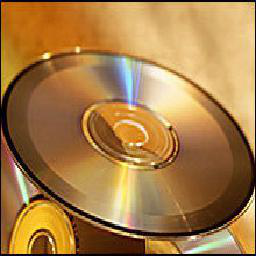

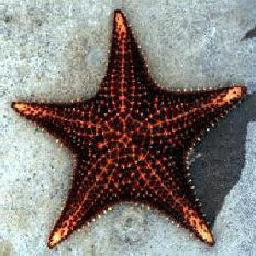

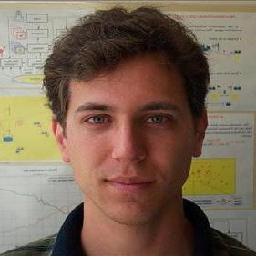

In [18]:
for filename in os.listdir('images/02/'):
    display(Image.open('images/02/' + filename))

## IMPLEMENTATION

### 1) Library import

As the first step in the implementation, all necessary imports have to be done.

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from IPython.display import display
import matplotlib.pyplot as plt
from skimage.io import imsave
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import shutil
import PIL
import os

### 2) Data import

The dataset has to be imported in order to make it available for the algorithm to be trained. In this step images are imported one after the another and appended to an array. Handling the data this way is required by the algorithm later on.

In [ ]:
# collect data - filling an array with images using a loop

data = []
for filename in os.listdir('images/Images_version_1/Train/'):
    data.append(img_to_array(load_img('images/Images_version_1/Train/'+filename)))
    print(filename)

# convert image array to float array of images
data = np.array(data, dtype=float)

# set up train data - consider RGB value 255
Xtrain = data
Xtrain = 1.0/255*Xtrain

### 3) Model setup

In [ ]:
model = Sequential()
# define an input layer (only once) - input data have shape of 256x256
# be aware that convolutional takes a 3D input so we need to shape to 256x256 and 1 for 1 color space
# specifing input shape sets also the weight for our model

# 1st filter, 2st kernel space (3,3) <-- size of filter
# activation relu -- good for deep learning (tangente)
# padding - output from kernel will decrease - padding does that it will fill up cells with 0's
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
# strides -> nr or tuple - how much kernel should be moved (2 px)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=["accuracy"])

model.summary()

## EVALUATION

## CONCLUSION